# Modeling Customer Subscription Preference with Apache Spark

Targeted Marketing campaigns are a very effective means of reaching prospective customers. However, such campaigns must be predicated on an empirical and systematic framework.  A predictive classification model derived from a supervised machine learning algorithm presents such a framework. Sections of a prescribed customer-base can be delineated for preferential marketing outreach based on classification output from a predictive model;  thereby saving scarce human and capital resources. 

A dataset that has been generated from a telemarketing campaign to sell long-term bank deposit subscriptions of a Retail Bank is used to train the predictive model. The dataset is obtained from the UCI Machine Learning Repository. The dataset is conceptually divided into, for every entry, a feature set and a target label. The feature set is comprised of client related data, contact-centre related data, and associated socio-economic indicators. The target label consists of a binary-class that indicates the subscription preference of a client - yes or no.

Apache Spark is a parallel cluster computing engine that is widely adopted for scaling data science projects. It is famed for its speed, support for multiple languages (Scala, Java, R, and Python), and advanced analytics offering one of which is the dedicated machine learning library, sparkML. The sparkML module is engaged to train the predictive model using the pyspark API, which is Python's syntax interface with Apache Spark computing engine.

## 1. ETL Process

We begin with the Extract-Transfrom-Load process. The dataset is 'extracted' from the source repository on the web and loaded into a Pandas DataFrame for onward pre-processing and exploratory analysis

### Import Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

### Extract and Load Dataset into a Pandas DataFrame

In [2]:
### Download zip file containing dataset, and read into a DataFrame

import wget
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
wget.download(url) # download into working directory

import zipfile
with zipfile.ZipFile('bank-additional.zip', 'r') as f: # unzip folder
    f.extractall()

df_raw = pd.read_csv('bank-additional-full.csv', sep=";") # read dataset into DataFrame

df_raw_trial = df_raw.copy() # make a copy of the dataframe
df_raw.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 2. Feature Engineering

Subsequent to ETL, the dataset is prepared for modeling. The feature-set is optimized such that it is amenable to the classification machine learning algorithms. This usually involves feature selection, feature transformation, dimension reduction, feature creation.

For our case-study, feature selection is implemented. Some pre-processing and exploratory steps are embedded as well.

In [3]:
# Obtain shape of dataset; No of Features

def dataset_shape(df):
    print('There are %d rows in the dataset' % df.shape[0])
    print('The total number of columns in dataset is %d; %d features and 1 target label' % \
          (df.shape[1], len(df.columns[:-1])))
    
dataset_shape(df_raw)

There are 41188 rows in the dataset
The total number of columns in dataset is 21; 20 features and 1 target label


In [117]:
# Rename the target feature

df_raw.rename(columns={'y':'Subscription_Status'}, inplace=True)

  Subscription_Status  Count Percentage
0                  no  36548     88.73%
1                 yes   4640     11.27%


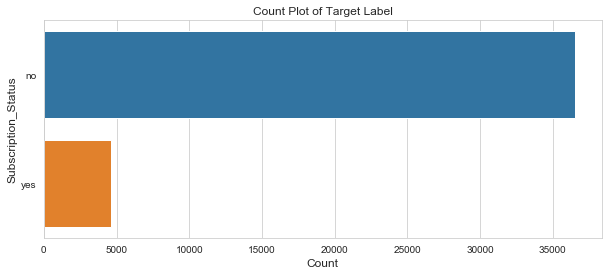

In [129]:
# Plot the distribution of the target label ('Subscription_Status') 

df_targetLabel = df_raw['Subscription_Status'].value_counts().to_frame().reset_index()
df_targetLabel.rename(columns={'index':'Subscription_Status', 'Subscription_Status':'Count'}, inplace=True)
df_targetLabel['Percentage'] = ((df_targetLabel['Count']/df_targetLabel['Count'].sum())*100).map('{:.2f}%'.format)

fig = plt.figure(figsize=(10,4))
ax = sns.countplot(y='Subscription_Status', data=df_raw)
ax.set_title('Count Plot of Target Label')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Subscription_Status', fontsize=12)
print(df_targetLabel)

_______________________________________________________________________________________________________________________________
The above chart reveals the target label is imbalanced. The subscription rates are generally low. This may have an adverse effect on the ability of the model to predict a positive subscription preference since it would have been trained on a dataset biased towards negative subscription preference. 

Consequently, the precision and recall evaluation metrics will be adopted to ascertain the performance of the trained models. These metrics are more suited for imbalanced classification problems.

In [6]:
# Check entire dataset for null values

for col in df_raw.columns:
    print(col, '\n', df_raw[col].isnull().value_counts(), '\n')

age 
 False    41188
Name: age, dtype: int64 

job 
 False    41188
Name: job, dtype: int64 

marital 
 False    41188
Name: marital, dtype: int64 

education 
 False    41188
Name: education, dtype: int64 

default 
 False    41188
Name: default, dtype: int64 

housing 
 False    41188
Name: housing, dtype: int64 

loan 
 False    41188
Name: loan, dtype: int64 

contact 
 False    41188
Name: contact, dtype: int64 

month 
 False    41188
Name: month, dtype: int64 

day_of_week 
 False    41188
Name: day_of_week, dtype: int64 

duration 
 False    41188
Name: duration, dtype: int64 

campaign 
 False    41188
Name: campaign, dtype: int64 

pdays 
 False    41188
Name: pdays, dtype: int64 

previous 
 False    41188
Name: previous, dtype: int64 

poutcome 
 False    41188
Name: poutcome, dtype: int64 

emp.var.rate 
 False    41188
Name: emp.var.rate, dtype: int64 

cons.price.idx 
 False    41188
Name: cons.price.idx, dtype: int64 

cons.conf.idx 
 False    41188
Name: cons.conf.idx,

_______________________________________________________________________________________________________________________________

Before proceeding with more exploratory analysis, the feature selection step is implemented.

A fundamental assumption in this study is that the client subscription preference is predicated upon an underlying propensity. In order words, a client already had a preference before being contacted by a telemarketing campaign. 

Besides, the objective of our modeling is to try to predict a client's preference (before they are contacted) so that telemarketing campaigns can be targeted. This would ultimately save cost and improve turn-around times.

Consequently, all contact-centre related features are dropped.

In [7]:
# Drop irrelevent Features: Those that refer to the involvement of the client with the Marketing contact-centre

Init_length = len(df_raw.columns) # initial column composition of dataset 

To_drop = ['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
           'previous', 'poutcome']

df_raw.drop(To_drop, axis=1, inplace=True)

print('The total number of columns in dataset is now %d' % (Init_length-len(To_drop)), '\n')
print('A total of %d columns have been dropped!' % len(To_drop))

The total number of columns in dataset is now 13 

A total of 8 columns have been dropped!


### Explore Categorical Features

The categorical features have widely distributed entries of 'unknown'. Such entries are explored and ultimately removed with the series of codes below:

In [135]:
# Explore 'unknown values': Display the number of 'unknown' values in each categorical features 

columns_categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan'] # Categorical Features

for col in columns_categorical:
    unknown_count = df_raw[df_raw[col]=='unknown'].shape[0]
    print(col + ':', unknown_count, '\n')

job: 330 

marital: 80 

education: 1731 

default: 8597 

housing: 990 

loan: 990 



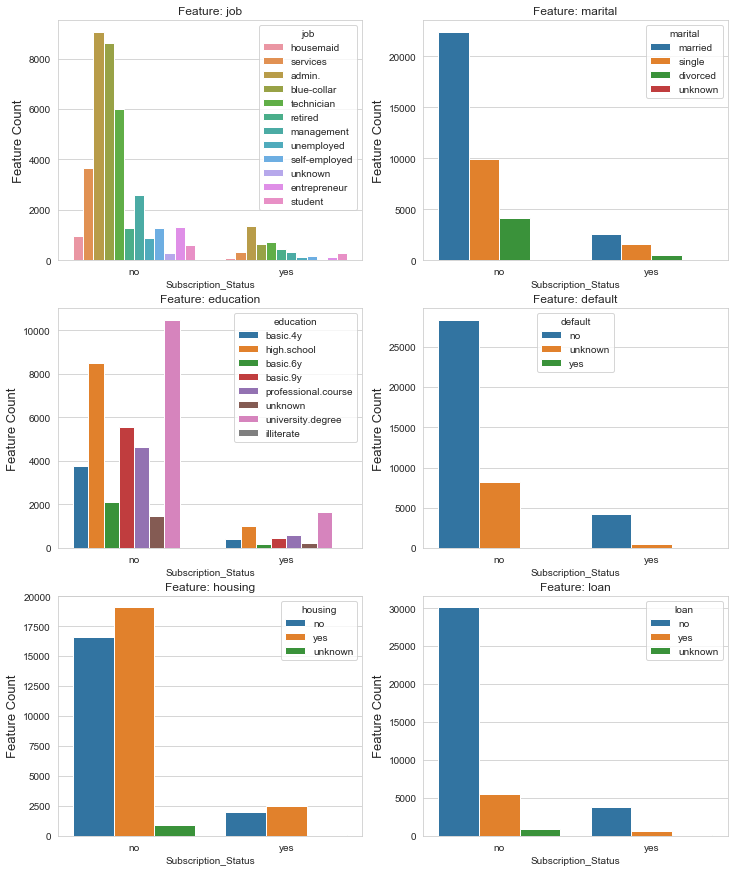

In [136]:
# Make subplots of Categorical Features against the target label('Subscription_Status') in order to assess information content

#fig = plt.figure(figsize=(20,25))
fig = plt.figure(figsize=(12,15))

for n, feature in zip(range(1,7), columns_categorical):
    axn = fig.add_subplot(3,2,n)
    sns.countplot(x='Subscription_Status', hue=feature, data=df_raw)
    axn.set_title('Feature: ' + feature, fontsize=12)
    axn.set_ylabel('Feature Count', fontsize=13)
    axn.set_xlabel('Subscription_Status', fontsize=10)
        

______________________________________________________________________________________________
The above chart relates the wide distribution of 'unknown' entries among the feature set. Such entries are subsequently dropped.

In addition, the 'default' feature (consists of classes 'yes' and 'no') is dropped due to its low information content: 
- more than 20% of the entries are 'unknown'
- only 0.007% are of the class 'yes'

In [9]:
# Drop all rows having 'unknown' values 
for col in columns_categorical:
    df_raw.drop(df_raw[df_raw[col]=='unknown'].index, axis=0, inplace=True)
    
# The 'default' feature is subsequently dropped as the plot reveals low information content with more than 20% 'unknown'
df_raw.drop('default', axis=1, inplace=True)

dataset_shape(df_raw)

There are 30488 rows in the dataset
The total number of columns in dataset is 12; 11 features and 1 target label


### Explore Numeric Features

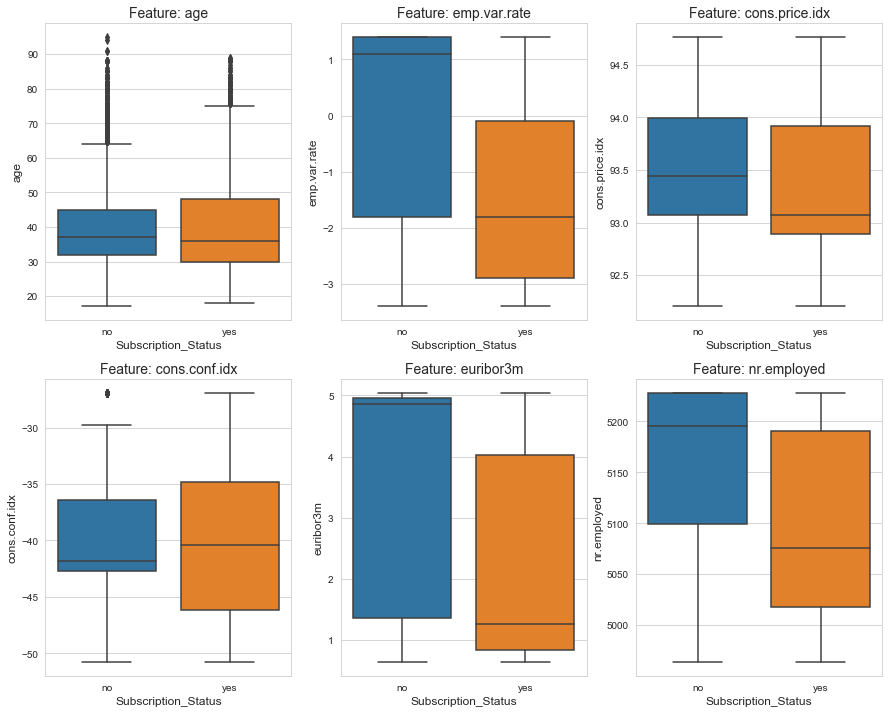

In [10]:
# Make boxplots of Numeric features against target label

columns_numerical = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] # Numerical Features
fig = plt.figure(figsize=(15,12))


for n, feature in zip(range(1,7), columns_numerical):
    sns.set_style("whitegrid")
    axn = fig.add_subplot(2,3,n)
    axn = sns.boxplot(x='Subscription_Status', y=feature, data=df_raw)
    axn.set_title('Feature: ' + feature, size=14)
    axn.set_ylabel(feature, size=12)
    axn.set_xlabel('Subscription_Status', size=12)
    #ax.set(ylabel = feature, xlabel = label)


In [11]:
# Dimensions of cleaned and feature-engineered dataset 

dataset_shape(df_raw)

There are 30488 rows in the dataset
The total number of columns in dataset is 12; 11 features and 1 target label


### Load Pandas DataFrame 'df_raw' as spark DataFrame

Now that the pre-processing, exploratory, and feature engineering steps are concluded, the pandas dataframe is loaded as a spark dataframe before the sparkML library of Apache Spark can be engaged.

However, before we begin modeling on the Apache Spark platform, a SparkSession must be created. The SparkSession is the entry point to programming Apache Spark with the Dataset and Dataframe API.

In [ ]:
# initialize pyspark
# Skip the code below if running on IBM Watson/Cloud Pak for Data

!pip install pyspark

!pip install findspark
import findspark
findspark.init()

In [13]:
# Create Sparksession

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
        
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession.builder.getOrCreate()

In [14]:
# Load pandas DataFrame 'df_raw' as spark DataFrame object. Define explicit schema to facilitate

m = list(df_raw.columns) # list of pandas dataframe columns

from pyspark.sql.types import * 

schema = StructType([
    StructField(m[0],IntegerType(), True),
    StructField(m[1],StringType(), True),
    StructField(m[2],StringType(), True),
    StructField(m[3],StringType(), True),
    StructField(m[4],StringType(), True),
    StructField(m[5],StringType(), True),
    StructField(m[6],FloatType(), True),
    StructField(m[7],FloatType(), True),
    StructField(m[8],FloatType(), True),
    StructField(m[9],FloatType(), True),
    StructField(m[10],FloatType(), True),
    StructField(m[11],StringType(), True)])


Market_pred = spark.createDataFrame(df_raw, schema)

Market_pred.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- emp.var.rate: float (nullable = true)
 |-- cons.price.idx: float (nullable = true)
 |-- cons.conf.idx: float (nullable = true)
 |-- euribor3m: float (nullable = true)
 |-- nr.employed: float (nullable = true)
 |-- Subscription_Status: string (nullable = true)



In [15]:
# Rename columns

column_old = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
column_new = ['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

for col_old, col_new in zip(column_old, column_new):
    Market_pred = Market_pred.withColumnRenamed(col_old, col_new)
#    Market_pred_binned = Market_pred_binned.withColumnRenamed(col_old, col_new)
    
            
Market_pred.columns

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'Subscription_Status']

In [17]:
# Confirm dimension of spark DataFrame (Market_pred)

print('Number of rows: %d' % Market_pred.count())
print('Number of columns: %d' % len(Market_pred.columns))

Number of rows: 30488
Number of columns: 12


## 3. Model Development

The customer preference prediction is a binary classification problem since the target label is either a 'yes' or 'no'. Logistic Regression, Support Vector Machine (SVM), and ensemble decision tree algorithms (Random Forest and Gradient-Boosted Trees) are all applicable.

Before the algorithms are implemented:
- the categorical features (including target label) are Indexed
- the Indexed features are oneHotEncoded
- Vector transformation of the feature set is effected
- the Vectorized feature set is normalized
- the dataset is split into training and test set (80:20)

In [19]:
# Create Indexed equivalent of categorical features and target label
from pyspark.ml.feature import StringIndexer

columns_categorical = ['job', 'marital', 'education', 'housing', 'loan', 'Subscription_Status']
columns_categorical_indexed = ['job_index', 'marital_index', 'education_index', 'housing_index', 'loan_index', 'label']

indexer = StringIndexer(inputCols= columns_categorical, outputCols=columns_categorical_indexed)
Market_indexed = indexer.fit(Market_pred).transform(Market_pred)
    
Market_indexed.columns

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'Subscription_Status',
 'loan_index',
 'housing_index',
 'label',
 'marital_index',
 'education_index',
 'job_index']

In [20]:
# One-Hot encode categorical features and target label
from pyspark.ml.feature import OneHotEncoder

columns_categorical_indexed = ['job_index', 'marital_index', 'education_index', 'housing_index', 'loan_index']
columns_encoded = ['job_encode', 'marital_encode', 'education_encode', 'housing_encode', 'loan_encode']

encoder = OneHotEncoder(inputCols=columns_categorical_indexed, outputCols=columns_encoded)
Market_encoded = encoder.fit(Market_indexed).transform(Market_indexed)
    
Market_encoded.columns    

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'Subscription_Status',
 'loan_index',
 'housing_index',
 'label',
 'marital_index',
 'education_index',
 'job_index',
 'housing_encode',
 'marital_encode',
 'education_encode',
 'loan_encode',
 'job_encode']

In [21]:
# Vector transformation of feature set
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

columns_vectors = ['age', 'job_encode', 'marital_encode', 'education_encode', 'housing_encode', 'loan_encode',
           'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


assembler = VectorAssembler(inputCols=columns_vectors, outputCol='features')
Market_encoded_vector = assembler.transform(Market_encoded)

Market_encoded_vector.columns


['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'Subscription_Status',
 'loan_index',
 'housing_index',
 'label',
 'marital_index',
 'education_index',
 'job_index',
 'housing_encode',
 'marital_encode',
 'education_encode',
 'loan_encode',
 'job_encode',
 'features']

In [22]:
# Normalize feature set

#from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StandardScaler

Norm = StandardScaler(inputCol='features',outputCol='features_norm')

Market_encoded_normalized = Norm.fit(Market_encoded_vector).transform(Market_encoded_vector)
Market_encoded_normalized.columns

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'Subscription_Status',
 'loan_index',
 'housing_index',
 'label',
 'marital_index',
 'education_index',
 'job_index',
 'housing_encode',
 'marital_encode',
 'education_encode',
 'loan_encode',
 'job_encode',
 'features',
 'features_norm']

In [23]:
# Train-Test Split

split = Market_pred.randomSplit([0.8, 0.2])
Market_train = split[0]
Market_test = split[1]   

#### Logistic Regression

In [87]:
# Train Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter = 10, regParam = 0.01, elasticNetParam = 0.8)
pipeline_lr = Pipeline(stages=[indexer, encoder, assembler, Norm, lr])

model_lr = pipeline_lr.fit(Market_train)
prediction_lr = model_lr.transform(Market_test)

# Evaluate Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

lr_evaluator = MulticlassClassificationEvaluator().setMetricName('weightedRecall')
lr_recall = '{:.3f}'.format(lr_evaluator.evaluate(prediction_lr))

lr_evaluator_f1 = MulticlassClassificationEvaluator().setMetricName('f1')
lr_f1 = '{:.3f}'.format(lr_evaluator_f1.evaluate(prediction_lr))

lr_evaluator_precision = MulticlassClassificationEvaluator().setMetricName('weightedPrecision')
lr_precision = '{:.3f}'.format(lr_evaluator_precision.evaluate(prediction_lr))

# create spark DataFrame to tabulate metric
Evaluation_lr = ([['Recall', lr_recall], ['Precision', lr_precision], ['f1', lr_f1]])
spark.createDataFrame(Evaluation_lr, ['Metric', ""]).show()

+---------+-----+
|   Metric|     |
+---------+-----+
|   Recall|0.867|
|Precision|0.752|
|       f1|0.806|
+---------+-----+



#### Support Vector Machine

In [89]:
# Train Model
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(maxIter = 10, regParam = 0.01)
pipeline_svm = Pipeline(stages=[indexer, encoder, assembler, Norm, svm])

model_svm = pipeline_svm.fit(Market_train)
prediction_svm = model_svm.transform(Market_test)

# Evaluate Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

svm_evaluator = MulticlassClassificationEvaluator().setMetricName('weightedRecall')
svm_recall = '{:.3f}'.format(svm_evaluator.evaluate(prediction_svm))

svm_evaluator_f1 = MulticlassClassificationEvaluator().setMetricName('f1')
svm_f1 = '{:.3f}'.format(svm_evaluator_f1.evaluate(prediction_svm))

svm_evaluator_precision = MulticlassClassificationEvaluator().setMetricName('weightedPrecision')
svm_precision = '{:.3f}'.format(svm_evaluator_precision.evaluate(prediction_svm))

# create spark DataFrame to tabulate metric 
Evaluation_svm = ([['Recall', svm_recall], ['Precision', svm_precision], ['f1', svm_f1]])
spark.createDataFrame(Evaluation_svm, ['Metric', ""]).show()

+---------+-----+
|   Metric|     |
+---------+-----+
|   Recall|0.867|
|Precision|0.752|
|       f1|0.806|
+---------+-----+



#### Random Forest

In [91]:
# Train Model
from pyspark.ml.classification import RandomForestClassifier

rndf = RandomForestClassifier(numTrees = 4, maxDepth = 18, seed = 2)
pipeline_rndf = Pipeline(stages=[indexer, encoder, assembler, rndf])

model_rndf = pipeline_rndf.fit(Market_train)
prediction_rndf = model_rndf.transform(Market_test)

# Evaluator Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

rndf_evaluator = MulticlassClassificationEvaluator().setMetricName('weightedRecall')
rndf_recall = '{:.3f}'.format(rndf_evaluator.evaluate(prediction_rndf))

rndf_evaluator_f1 = MulticlassClassificationEvaluator().setMetricName('f1')
rndf_f1 = '{:.3f}'.format(rndf_evaluator_f1.evaluate(prediction_rndf))

rndf_evaluator_precision = MulticlassClassificationEvaluator().setMetricName('weightedPrecision')
rndf_precision = '{:.3f}'.format(rndf_evaluator_precision.evaluate(prediction_rndf))

# create spark DataFrame to tabulate metric
Evaluation_rndf = ([['Recall', rndf_recall], ['Precision', rndf_precision], ['f1', rndf_f1]])
spark.createDataFrame(Evaluation_rndf, ['Metric', ""]).show()

+---------+-----+
|   Metric|     |
+---------+-----+
|   Recall|0.862|
|Precision|0.834|
|       f1|0.842|
+---------+-----+



#### Gradient-Boosted Trees

In [92]:
# Train Model
from pyspark.ml.classification import GBTClassifier

GBT = GBTClassifier(maxIter = 10, maxDepth = 8, seed =2)
pipeline_GBT = Pipeline(stages=[indexer, encoder, assembler, GBT])

model_GBT = pipeline_GBT.fit(Market_train)
prediction_GBT = model_GBT.transform(Market_test)

# Evaluate Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

GBT_evaluator = MulticlassClassificationEvaluator().setMetricName('weightedRecall')
GBT_recall = '{:.3f}'.format(GBT_evaluator.evaluate(prediction_GBT))

GBT_evaluator_f1 = MulticlassClassificationEvaluator().setMetricName('f1')
GBT_f1 = '{:.3f}'.format(GBT_evaluator_f1.evaluate(prediction_GBT))

GBT_evaluator_precision = MulticlassClassificationEvaluator().setMetricName('weightedPrecision')
GBT_precision = '{:.3f}'.format(GBT_evaluator_precision.evaluate(prediction_GBT))

# create spark DataFrame to tabulate metric
Evaluation_GBT = ([['Recall', GBT_recall], ['Precision', GBT_precision], ['f1', GBT_f1]])
spark.createDataFrame(Evaluation_GBT, ['Metric', ""]).show()

+---------+-----+
|   Metric|     |
+---------+-----+
|   Recall|0.869|
|Precision|0.840|
|       f1|0.844|
+---------+-----+



_______________________________________________________________________________________________________________________________
The evaluation metric for all the models are put in a single table for comparison:  

In [85]:
# Tabulate evaluation metric in a spark DataFrame

Evaluation = ([['Logistic Regression', lr_recall, lr_f1, lr_precision], 
               ['SVM', svm_recall, svm_f1, svm_precision], 
               ['Random Forest', rndf_recall, rndf_f1, rndf_precision], 
               ['Gradient-Boosted', GBT_recall, GBT_f1, GBT_precision]])

spark.createDataFrame(Evaluation, ["", 'Recall', 'f1', 'Precision']).show()

+-------------------+------+-----+---------+
|                   |Recall|   f1|Precision|
+-------------------+------+-----+---------+
|Logistic Regression| 0.867|0.806|    0.752|
|                SVM| 0.867|0.806|    0.752|
|      Random Forest| 0.862|0.842|    0.834|
|   Gradient-Boosted| 0.869|0.844|    0.840|
+-------------------+------+-----+---------+



## Model Tuning

The most promising algorithm is subjected to hyperparameter-tuning using the Crossvalidation and Gridsearch feature of SparkML. Hyperparameters are those model variables or parameters that can be optimized to obtain better model outputs.

The Random Forest and Gradient-Boosted Tree models have comparable performance. However, the Random Forest model is preferred for its lower computational cost and amenability to parallel computing.

### Random Forest

In [93]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Set up the grid
Market_grid = ParamGridBuilder() \
                .addGrid(rndf.maxDepth, [15, 18, 25]) \
                .addGrid(rndf.numTrees, [3, 5, 8]) \
                .addGrid(rndf.seed, [2, 3, 5]) \
                .build()
            
# Create Crossvalidation object
Market_cross_val = CrossValidator(
                estimator = pipeline_rndf,
                estimatorParamMaps = Market_grid,
                evaluator = MulticlassClassificationEvaluator(),
                numFolds = 4)

# Train and Evaluate CrossValidator
Model_cross_val = Market_cross_val.fit(Market_train)
prediction_cross_val = Model_cross_val.transform(Market_test)

rndff_evaluator_f1 = MulticlassClassificationEvaluator().setMetricName('f1')
rndff_f1 = '{:.3f}'.format(rndff_evaluator_f1.evaluate(prediction_cross_val))

rndff_evaluator_precision = MulticlassClassificationEvaluator().setMetricName('weightedPrecision')
rndff_precision = '{:.3f}'.format(rndff_evaluator_precision.evaluate(prediction_cross_val))

rndff_evaluator = MulticlassClassificationEvaluator().setMetricName('weightedRecall')
rndff_recall = '{:.3f}'.format(rndff_evaluator.evaluate(prediction_cross_val))

# create spark DataFrame to tabulate metric
Evaluation_f = ([['Recall', rndff_recall], ['Precision', rndff_precision], ['f1', rndff_f1]])
spark.createDataFrame(Evaluation_f, ['Metric', ""]).show()

+---------+-----+
|   Metric|     |
+---------+-----+
|   Recall|0.869|
|Precision|0.843|
|       f1|0.849|
+---------+-----+



### Conclusion

A model has been trained to predict customer preference for purchasing subscriptions from a retail bank. This serves to direct scarce human and capital resources towards high potential customers defined by the predictive model. The dataset with which the model was trained consists of features relating to client information, product detail, and socio-economic indicators. The sparkML library from the Apache Spark distributed computing engine was engaged alongside the pyspark API. The Random Forest model is preferred for its robust performance, lower computational cost, and amenability to parallel computing.





### References

[1] S. Moro, P. Cortez and P. Rita (2014). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[2] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014